# Statistics with Confidence

Have you heard that 78% statistics are made up? I am sure you can prove it mathematically, just choose your samples carefully. These jokes often lend bad reputation to statistics, but ignoring statistics can hurt business decisions, and sometimes laws require it (See [US FDA's Code of Federal Regulations for medical devices](https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfcfr/CFRSearch.cfm?fr=820.250))! Then how do we build confidence in statistics?

This article shows how you can add confidence to statistics in two different use cases:
- Numbers: Confidence in averages or ranges
- Pass/Fail: Confidence in passing rate

## Numbers

Suppose we have an apple packing business. We get our apples from different orchards. We package them in bags and sell them to grocery stores. Our main business is medium sized apples, with average weight of 180 grams. We want to keep all apples in a bag more or less the same size, say within 10% of the average. Let's see how to figure out confidence in average AKA mean.

### Confidence in Mean

Each truck from an orchard brings a few thousand apples. We want to find out the average weight of an apple in each shipment. We don't want to weigh each apple, that will take too long. We can then weigh only a few to guess the average weight. If we weight more number of apples, we will get a better estimate of the actual average weight.

Suppose we get our apples from two orchards, and one of them throws in smaller apples sometimes. Let's call the ones that run a tight operation "Tighters" and the other one "Loosers". Can we catch them if we weight the first 10 apples? Let's try with some random numbers.

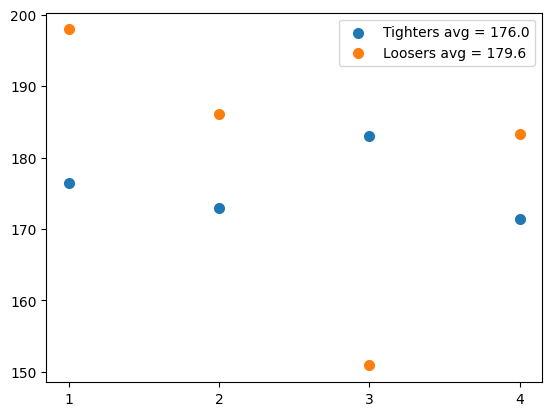

In [9]:
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import random
import scipy.stats as stats

@dataclass
class OrchardStats:
    name: str
    actual_mean: float = 0
    actual_range: float = 0
    num_samples: int = 0
    samples: list[float] = field(default_factory=list)

    def make_samples(self) -> None:
        (lo_lim, hi_lim) = (self.actual_mean - self.actual_range, self.actual_mean + self.actual_range)
        self.samples = [random.uniform(lo_lim, hi_lim) for _ in range(num_samples)]
    
    def plot_test_samples(self, num_test_samples: int, **kwargs) -> None:
        self.test_samples = self.samples[:num_test_samples]
        x_ax = range(1, num_test_samples+1)
        test_mean = sum(self.test_samples)/num_test_samples
        plt.scatter(x_ax, self.test_samples, marker=".", label=f"{self.name} avg = {test_mean:.1f}", **kwargs)
    
    def plot_samples_avg(self, num_test_samples: int, **kwargs) -> None:
        self.plot_test_samples(num_test_samples)
        x_ax = range(num_test_samples)
        self.test_avg = [sum(self.test_samples[:k+1])/(k+1) for k in x_ax]
        plt.plot(x_ax, self.test_avg, **kwargs)

random.seed(7)
num_samples = 20000

tighters = OrchardStats("Tighters", actual_mean=180, actual_range=10, num_samples=num_samples)
tighters.make_samples()

loosers = OrchardStats("Loosers", actual_mean=175, actual_range=25, num_samples=num_samples)
loosers.make_samples()

tighters.plot_test_samples(4, linewidths=5)
loosers.plot_test_samples(4, linewidths=5)
plt.xticks(range(1,5))
plt.legend()


Try to run the above code a few times. Sometimes the shipment from Loosers has higher average weight! What would happen if we weighted some more test samples? Let's see how the average weight changes as we increase the number of test samples.

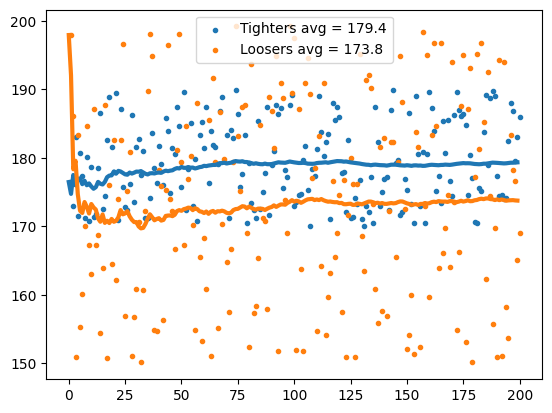

In [10]:

num_test_samples = 200
tighters.plot_samples_avg(num_test_samples, linewidth=3)
loosers.plot_samples_avg(num_test_samples, linewidth=3)

plt.legend()



Only after about 25 or so samples we started seeing stable difference between the samples from these two orchards. The plot of averages gets more and more stable as the number of samples increases. Statistics defines the term _Confidence Interval of Mean_ to denote the range of values within which the mean will be, given a certain level of confidence. It is typical to see 99% or 95% confidence intervals. Mathematically, the mean of the population follows the Gaussian or normal distribution, irrespective of the probability distribution of the samples. You can read more about it on [NIST's Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/eda/section3/eda352.htm)

Let's plot the confidence intervals for both these averages using 95% confidence intervals.


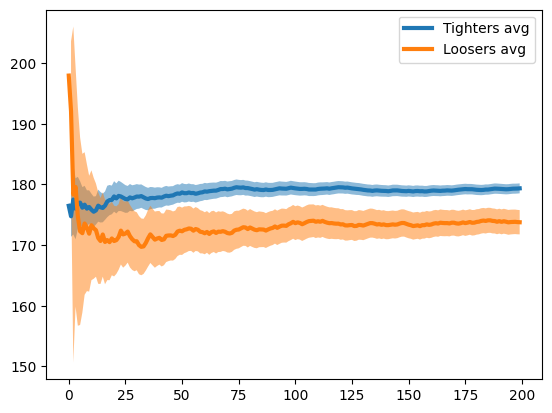

In [11]:
def plot_avg_confidence(orchard: OrchardStats) -> None:
    num_test_samples = len(orchard.test_samples)
    x_ax = range(num_test_samples)
    x_ax_1 = x_ax[1:]
    # Standard error of mean, prefix first sample
    sem = [0] + [stats.sem(orchard.test_samples[:k+1]) for k in x_ax_1]
    z_score = 1.96 # For 95% confidence
    mean_lo = [orchard.test_avg[k]-z_score*sem[k] for k in x_ax_1]
    mean_hi = [orchard.test_avg[k]+z_score*sem[k] for k in x_ax_1]

    plt.plot(x_ax, orchard.test_avg, label=f"{orchard.name} avg", linewidth=3)
    plt.fill_between(x_ax_1, mean_lo, mean_hi, alpha=0.5)
    
plot_avg_confidence(tighters)
plot_avg_confidence(loosers)
plt.legend()



### Estimate of Range: Tolerance Interval 
Confidence interval of 95% does not mean that 95% of the _samples_ wll fall in that interval or range. That is called the _Tolerance Interval_. If you know what the probability distribution of the population is, it is easy to calculate. If you don't, using median and middle 95% values is reasonable approximation.

(19.5, 1, 39)


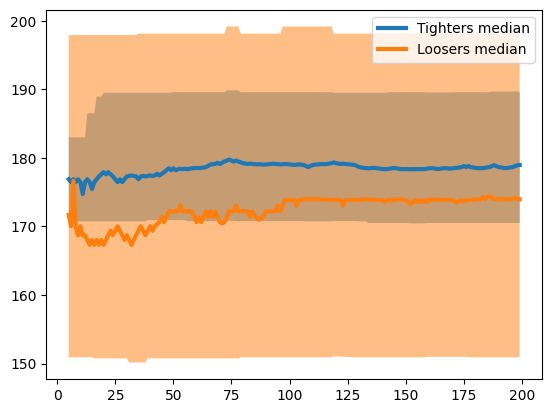

In [22]:
from math import floor

def get_quantile_indices(n: int, q: float) -> tuple:
    diff = floor(n - q * n)
    half_diff = diff // 2
    return (half_diff, n-1-half_diff)

def get_quantiles(data: list, tolerance:float = 0.95) -> tuple:
    sorted_data = sorted(data)
    n = len(data)
    median_index = (n + 1) // 2 - 1
    med = sorted_data[median_index] if n % 2 == 1 else (sorted_data[median_index] + sorted_data[median_index+1])/2
    (lo_id, hi_id) = get_quantile_indices(n, tolerance)
    # Increment hi_id for higher confidence
    hi_id = min(hi_id+1, n-1)
    tol_lo = sorted_data[lo_id]
    tol_hi = sorted_data[hi_id]
    return (med, tol_lo, tol_hi)

def test_quantiles():
    assert get_quantiles(range(5)) == (2, 0, 4)
    assert get_quantiles(range(39)) == (19, 0, 38)
    assert get_quantiles(range(40)) == (19.5, 1, 39)

def plot_median_tolerance(orchard: OrchardStats) -> None:
    num_test_samples = len(orchard.test_samples)
    
    median = []
    tolerance_lo = []
    tolerance_hi = []
    for k in range(5,num_test_samples):
        (med, lo, hi) = get_quantiles(orchard.test_samples[:k+1])
        median.append(med)
        tolerance_lo.append(lo)
        tolerance_hi.append(hi)

    x_ax = range(5,num_test_samples)
    plt.plot(x_ax, median, label=f"{orchard.name} median", linewidth=3)
    plt.fill_between(x_ax, tolerance_lo, tolerance_hi, alpha=0.5)

test_quantiles()
plot_median_tolerance(tighters)
plot_median_tolerance(loosers)
plt.legend()


### Confidence in Tolerance Interval

Just like confidence interval around mean, there is confidence interval around tolerance. For the mathematical details you can see the textbook [Introduction to Mathematical Statistics](https://online.stat.psu.edu/stat415/lesson/19/19.2). Let's say, we fix the tolerance interval as second value to last-but-one value after sorting the data. At 40 samples, this represents exactly 95% of the sorted samples. What is our confidence that this range actually represents the 95% tolerance interval?

You might have noticed a small tweak of incrementing the upper index for tolerance by 1. This was done to increase the level of confidence in the estimate of the tolerance interval. See the difference this adjustment made in the plot below.

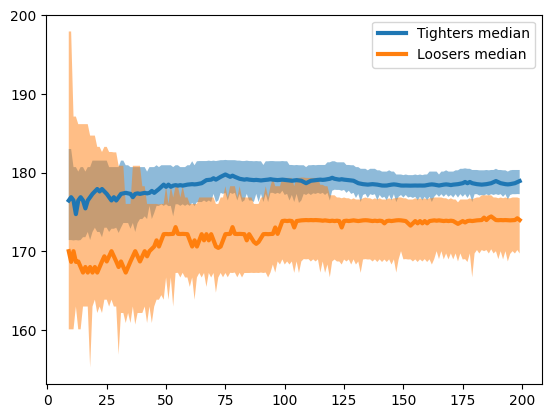

In [8]:

from relistats.quantile import confidence_interval_of_median

def plot_median_confidence(orchard: OrchardStats) -> None:
    num_test_samples = len(orchard.test_samples)
    x_ax = range(num_test_samples)
    x_ax_1 = x_ax[9:]
    med = []
    median_lo = []
    median_hi = []
    for n in x_ax_1:
        samples = sorted(orchard.test_samples[:n])
        num_samples = len(samples)
        median_index = (num_samples + 1) // 2 - 1
        
        sample_median = samples[median_index] if num_samples % 2 == 1 else (samples[median_index] + samples[median_index+1])/2
        med.append(sample_median)
        (v_lo, v_hi) = confidence_interval_of_median(0.95, samples)
        median_lo.append(v_lo)
        median_hi.append(v_hi)

    plt.plot(x_ax_1, med, label=f"{orchard.name} median", linewidth=3)
    plt.fill_between(x_ax_1, median_lo, median_hi, alpha=0.5)
    
plot_median_confidence(tighters)
plot_median_confidence(loosers)
plt.legend()




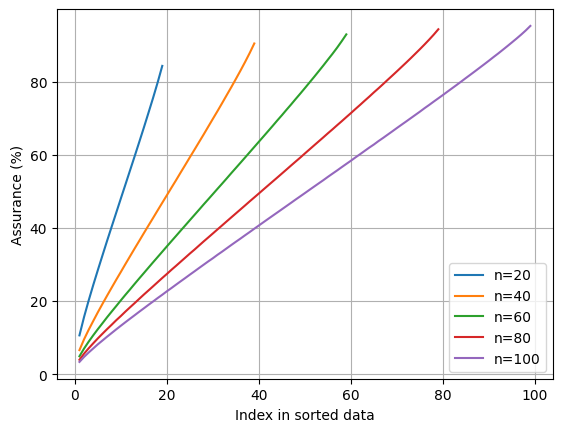

In [6]:
from relistats.quantile import assurance_in_quantile

for n in range(20, 101, 20):
    x_ax = range(1, n)
    assur = [assurance_in_quantile(k, n)*100 for k in x_ax]
    plt.plot(x_ax, assur, label=f"n={n}")

plt.xlabel("Index in sorted data")
plt.ylabel("Assurance (%)")
plt.grid()
plt.legend()
